[View in Colaboratory](https://colab.research.google.com/github/tnmurthy/Data-Science/blob/master/Predicting_Gaze_with_Eye_Tracking_for_Everyone.ipynb)

# Detecting Gaze in using the "Eye Tracking for Everyone" Neural Network

This will go through the process of extracting the features from an image that are needed for the neural network, testing the input, and displaying the output.

## Extracting the Inputs from an Image using OpenCV

The neural network requires as inputs:
* an image of the left eye, (224x224)
* an image of the right eye (224x224)
* an image of the fafce (224x224)
* a 625 array representing where in a 25x25 grid the face is

Here we will use OpenCV to extract this from a single image.  Much of this code is based on the instruction at 
https://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html

In [0]:
!pip install open cv
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2

In [0]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import cv2
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline
# filter out the warnings
import warnings
warnings.filterwarnings('ignore')

Download the models from the github repository

In [0]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_eye.xml -P drive/gaze
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml -P drive/gaze

In [0]:
cascades_path = 'drive/gaze/'
face_cascade = cv2.CascadeClassifier(cascades_path + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cascades_path + 'haarcascade_eye.xml')

In [0]:
import time
import os

def download_image(image_url):
    os.system('wget ' + image_url + ' -P drive/gaze')
    file_path_parts = image_url.split('/')
    return 'drive/gaze/' + file_path_parts[-1]

def current_time():
    return int(round(time.time() * 1000))

def detect_eyes(face, img, gray):
    [x,y,w,h] = face
    roi_gray = gray[y:y+h, x:x+w]

    eyes = eye_cascade.detectMultiScale(roi_gray)
    eyes_sorted_by_size = sorted(eyes, key=lambda x: -x[2])
    largest_eyes = eyes_sorted_by_size[:2]
    # sort by x position
    largest_eyes.sort(key=lambda x: x[0])
    # offset by face start
    return list(map(lambda eye: [face[0] + eye[0], face[1] + eye[1], eye[2], eye[3]], largest_eyes))

def get_face_grid(face, frameW, frameH, gridSize):
    faceX,faceY,faceW,faceH = face

    return faceGridFromFaceRect(frameW, frameH, gridSize, gridSize, faceX, faceY, faceW, faceH, False)

def extract_image_features(image_url):
    image_path = download_image(image_url)
    img = cv2.imread(image_path)
    start_ms = current_time()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face_detections = face_cascade.detectMultiScale(gray, 1.3, 5)
    #  print('face detection took ' + str((current_time() - start_ms) / 1000.))

    left_to_right_face_detections = sorted(face_detections, key=lambda detection: detection[0])

    faces = []
    face_features = []
    for [x,y,w,h] in left_to_right_face_detections:
        face = [x, y, w, h]
        #  start_eyes = current_time()
        eyes = detect_eyes(face, img, gray)
        #  print('eye extraction '  + str((current_time() - start_eyes) / 1000.))
        face_grid = get_face_grid(face, img.shape[1], img.shape[0], 25)

        faces.append(face)
        face_features.append([eyes, face_grid])

    duration_ms = current_time() - start_ms
    #  print("Face and eye extraction took: ", str(duration_ms / 1000) + "s")

    return img, faces, face_features

In [0]:
file_url = 'http://cdn.newsapi.com.au/image/v1/335a6997d394c4d65a00aadc99c4fd44'
img, faces, face_features = extract_image_features(file_url)

In [0]:
# This code is converted from https://github.com/CSAILVision/GazeCapture/blob/master/code/faceGridFromFaceRect.m

# Given face detection data, generate face grid data.
#
# Input Parameters:
# - frameW/H: The frame in which the detections exist
# - gridW/H: The size of the grid (typically same aspect ratio as the
#     frame, but much smaller)
# - labelFaceX/Y/W/H: The face detection (x and y are 0-based image
#     coordinates)
# - parameterized: Whether to actually output the grid or just the
#     [x y w h] of the 1s square within the gridW x gridH grid.

def faceGridFromFaceRect(frameW, frameH, gridW, gridH, labelFaceX, labelFaceY, labelFaceW, labelFaceH, parameterized):

    scaleX = gridW / frameW
    scaleY = gridH / frameH
    
    if parameterized:
      labelFaceGrid = np.zeros(4)
    else:
      labelFaceGrid = np.zeros(gridW * gridH)
    
    grid = np.zeros((gridH, gridW))

    # Use one-based image coordinates.
    xLo = round(labelFaceX * scaleX)
    yLo = round(labelFaceY * scaleY)
    w = round(labelFaceW * scaleX)
    h = round(labelFaceH * scaleY)

    if parameterized:
        labelFaceGrid = [xLo, yLo, w, h]
    else:
        xHi = xLo + w
        yHi = yLo + h

        # Clamp the values in the range.
        xLo = int(min(gridW, max(0, xLo)))
        xHi = int(min(gridW, max(0, xHi)))
        yLo = int(min(gridH, max(0, yLo)))
        yHi = int(min(gridH, max(0, yHi)))

        faceLocation = np.ones((yHi - yLo, xHi - xLo))
        grid[yLo:yHi, xLo:xHi] = faceLocation

        # Flatten the grid.
        grid = np.transpose(grid)
        labelFaceGrid = grid.flatten()
        
    return labelFaceGrid
      

In [0]:
def set_title_and_hide_axis(title):
    plt.title(title)
    plt.axes().get_xaxis().set_visible(False)
    plt.axes().get_yaxis().set_visible(False)

def render_face_grid(face_grid):
    to_print = np.copy(face_grid)
    result_image = np.copy(to_print).reshape(25, 25).transpose()
    plt.figure()
    set_title_and_hide_axis('Face grid')
    plt.imshow(result_image)

def show_extraction_results(img, faces, face_features):
    plt.figure(figsize=(10,10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), interpolation="bicubic")

    for i, face in enumerate(faces):
        print('Face #' + str(i))
        eyes, face_grid = face_features[i]
        [x, y, w, h] = face
        set_title_and_hide_axis('Extracted face image')
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

        for [ex,ey,ew,eh] in eyes:
            cv2.rectangle(img,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        
        plt.figure()
        render_face_grid(face_grid)

## Load Image, extract face and eye features

In [0]:
img, faces, face_features = extract_image_features('http://dreamicus.com/data/face/face-04.jpg')

Face #0


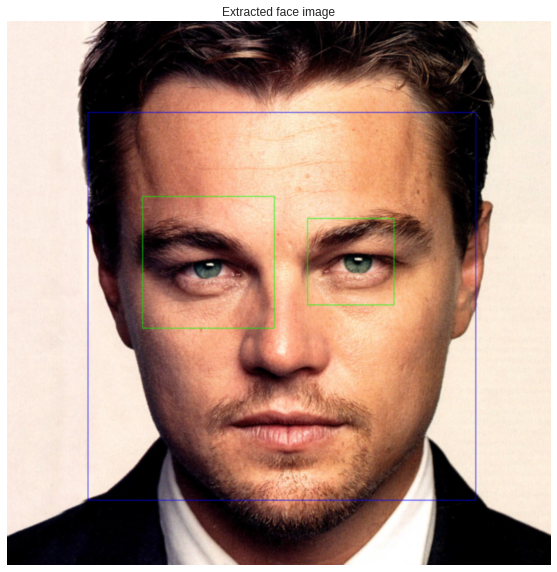

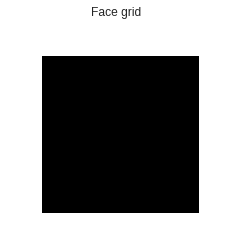

In [0]:
show_extraction_results(img, faces, face_features)

# Feeding the Input through the Network

Here we will load the model from https://github.com/CSAILVision/GazeCapture.  We will use the 25x snapshot which is trained to handle variations in the images.

In [0]:
!apt install -y caffe-cuda
import caffe

In [0]:
# Download the model
!wget https://raw.githubusercontent.com/CSAILVision/GazeCapture/master/models/itracker_deploy.prototxt -P drive/gaze
!wget https://github.com/CSAILVision/GazeCapture/raw/master/models/snapshots/itracker25x_iter_92000.caffemodel -P drive/gaze
!wget https://github.com/CSAILVision/GazeCapture/raw/master/models/mean_images/mean_face_224.mat -P drive/gaze
!wget https://github.com/CSAILVision/GazeCapture/raw/master/models/mean_images/mean_left_224.mat -P drive/gaze
!wget https://github.com/CSAILVision/GazeCapture/raw/master/models/mean_images/mean_right_224.mat -P drive/gaze

In [0]:
caffe.set_mode_gpu()

model_root = "drive/gaze/"

model_def = model_root + 'itracker_deploy.prototxt'
model_weights = model_root + 'itracker25x_iter_92000.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

In [0]:
# set the batch size to 1
def set_batch_size(batch_size):
    net.blobs['image_left'].reshape(batch_size, 3, 224, 224)
    net.blobs['image_right'].reshape(batch_size, 3, 224, 224)
    net.blobs['image_face'].reshape(batch_size, 3, 224, 224)
    net.blobs['facegrid'].reshape(batch_size, 625, 1, 1)   
    
set_batch_size(1)

In [0]:
# for each layer, show the output shape
for layer_name, blob in net.blobs.items():
    print(layer_name + '\t' + str(blob.data.shape))

In [0]:
# load the mean images
import scipy.io

def get_mean_image(file_name):
    image_mean = np.array(scipy.io.loadmat(model_root + file_name)['image_mean'])
    image_mean = image_mean.reshape(3, 224, 224)
    
    return image_mean.mean(1).mean(1)

mu_face = get_mean_image('mean_face_224.mat')
mu_left_eye = get_mean_image('mean_left_224.mat')
mu_right_eye = get_mean_image('mean_right_224.mat')

print(mu_face)
print(mu_left_eye)
print(mu_right_eye)

[118.74723 129.16585 113.75103]
[114.61925  102.43724  127.923225]
[108.997314  97.88837  123.50221 ]


In [0]:
# create transformer for the input called 'data'
def create_image_transformer(layer_name, mean_image=None):  
    transformer = caffe.io.Transformer({layer_name: net.blobs[layer_name].data.shape})

    transformer.set_transpose(layer_name, (2,0,1))  # move image channels to outermost dimension
    if mean_image is not None:
        transformer.set_mean(layer_name, mean_image)            # subtract the dataset-mean value in each channel
    return transformer

left_eye_transformer = create_image_transformer('image_left', mu_left_eye)
right_eye_transformer = create_image_transformer('image_right', mu_right_eye)
face_transformer = create_image_transformer('image_face', mu_face)

# face grid transformer just passes through the data
face_grid_transformer = caffe.io.Transformer({'facegrid': net.blobs['facegrid'].data.shape})

In [0]:
import sys

def crop_image(img, crop):
    return img[crop[1]:crop[1]+crop[3],crop[0]:crop[0]+crop[2],:] 

def test_face(img, face, face_feature):
    eyes, face_grid = face_feature

    if len(eyes) < 2:
        return None

    start_ms = current_time()
    transformed_right_eye = right_eye_transformer.preprocess('image_right', crop_image(img, eyes[0]))
    #print(eyes[0].shape, transformed_right_eye[0].shape)
    transformed_left_eye = left_eye_transformer.preprocess('image_left', crop_image(img, eyes[1]))
    transformed_face = face_transformer.preprocess('image_face', crop_image(img, face))
    transformed_face_grid = face_grid.reshape(1, 625, 1, 1)
    
    net.blobs['image_left'].data[...] = transformed_left_eye
    net.blobs['image_right'].data[...] = transformed_right_eye
    net.blobs['image_face'].data[...] = transformed_face
    net.blobs['facegrid'].data[...] = transformed_face_grid
    
    output = net.forward()
    net.forward()
    print("Feeding through the network took " + str((current_time() - start_ms) * 1. / 1000) + "s")
    
    return np.copy(output['fc3'][0])
    

def test_faces(img, faces, face_features):
    outputs = []
    for i, face in enumerate(faces):
        output = test_face(img, face, face_features[i])

        outputs.append(output)

    return outputs

In [0]:
outputs = test_faces(img, faces, face_features)
print("The outputs:", outputs)

Feeding through the network took 0.655s
The outputs: [array([ 0.2546527, -0.8897899], dtype=float32)]


## Running on the GPU

In [0]:
# run once to upload the network to gpu
outputs = test_faces(img, faces, face_features)

# then timeit
%timeit test_faces(img, faces, face_features)

Feeding through the network took 0.214s
Feeding through the network took 0.21s
Feeding through the network took 0.218s
Feeding through the network took 0.224s
Feeding through the network took 0.217s
1 loop, best of 3: 217 ms per loop


In [0]:
# units in cm
screen_w = 5.58
screen_h = 10.45
screen_aspect = screen_w / screen_h
camera_l = 2.299
camera_t = 0.91
screen_t = 1.719
screen_l = 0.438
phone_w = 6.727
phone_h = 13.844
screen_from_camera = [screen_t - camera_t, screen_l - camera_l]

camera_coords_percentage = [camera_t / phone_h, camera_l / phone_w]

#iphone 8 screen w and screen height from https://www.paintcodeapp.com/news/ultimate-guide-to-iphone-resolutions
screenW = 375
screenH = 667

phone_w_to_screen = phone_w / screen_w
phone_h_to_screen = phone_h / screen_h

In [0]:
def render_gaze(full_image, camera_center, cm_to_px, output):
    xScreen = output[0]
    yScreen = output[1]
    pixelGaze = [round(camera_center[0] - yScreen * cm_to_px), round(camera_center[1] + xScreen * cm_to_px)]
    
    cv2.circle(full_image,(int(pixelGaze[1]), int(pixelGaze[0])), 30, (0, 0, 255), -1)

    
def render_gazes(img, outputs):
    full_image = np.ones((round(img.shape[0] * 2), round(img.shape[1] * 2), 3), dtype=np.uint8)

    full_image_center = [round(full_image.shape[0] * 0.2), round(full_image.shape[1] *.5)]
    camera_center = full_image_center

    cm_to_px = img.shape[0] * 1. / screen_h

    screen_from_camera_px = [round(screen_from_camera[0] * cm_to_px), round(screen_from_camera[1] * cm_to_px)]

    screen_start = [camera_center[0] + screen_from_camera_px[0], camera_center[1] + screen_from_camera_px[1]]
    
    full_image[screen_start[0]:screen_start[0] + img.shape[0], screen_start[1]:screen_start[1] + img.shape[1], :] = img[:, :, :]

    cv2.circle(full_image,(camera_center[1],camera_center[0]), 30, (255, 0, 0), -1)
    
    for output in outputs:
        if output is not None:
            render_gaze(full_image, camera_center, cm_to_px, output)

    plt.figure(figsize=(10,10))
    plt.axes().get_xaxis().set_visible(False)
    plt.axes().get_yaxis().set_visible(False)
    plt.imshow(cv2.cvtColor(full_image, cv2.COLOR_BGR2RGB), interpolation="bicubic")    

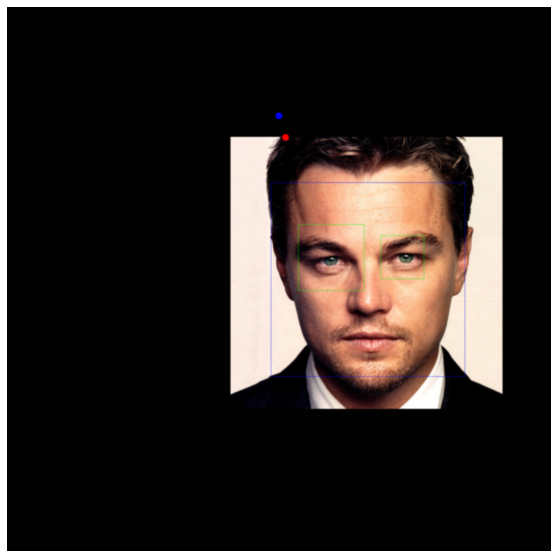

In [0]:
render_gazes(img, outputs)

In [0]:
# lets create a reusable function to extract the features, pass through the network, and render output
def test_and_render(image_url, show_details=False):
    img, faces, face_features = extract_image_features(image_url)
    outputs = test_faces(img, faces, face_features)

    if show_details:        
        show_extraction_results(img, faces, face_features)

    render_gazes(img, outputs)

Feeding through the network took 0.097s
Feeding through the network took 0.095s


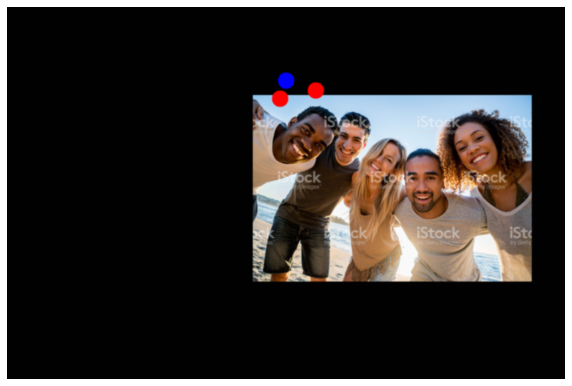

In [0]:
test_and_render('https://media.istockphoto.com/photos/happy-group-of-friends-at-the-beach-picture-id505259176')

In [0]:
test_and_render('http://a2.espncdn.com/combiner/i?img=%2Fphoto%2F2018%2F0305%2Fr336842_1296x729_16-9.jpg')

NameError: ignored